In [5]:
# src/train_model.py

import pandas as pd
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


def generate_labels(df):
    """
    Create proxy labels:
    - Label = 1 if repay_borrow_ratio > 0.5 and no liquidation
    - Label = 0 otherwise
    """
    df['label'] = ((df['repay_borrow_ratio'] > 0.5) & (df['total_liquidation'] == 0)).astype(int)
    print("Label distribution:\n", df['label'].value_counts())
    return df


def log_transform(df, cols):
    for col in cols:
        df[col] = np.log1p(df[col])  # log(1 + x), safe for zeroes
    return df


def train_credit_model(
    csv_path="data/wallet_features.csv",
    save_path="data/credit_model.pkl"
):
    # Load feature data
    df = pd.read_csv(csv_path)

    # Step 1: Create proxy labels
    df = generate_labels(df)

    # Step 2: Feature selection
    feature_cols = [
        'total_deposit', 'total_borrow', 'total_repay',
        'repay_borrow_ratio', 'total_liquidation', 'tx_count'
    ]

    # Step 3: Log-transform high-range features
    log_cols = ['total_deposit', 'total_borrow', 'total_repay', 'tx_count']
    df = log_transform(df, log_cols)

    # Step 4: Prepare X and y
    X = df[feature_cols]
    y = df['label']

    # Step 5: Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Step 6: Evaluate
    y_pred = model.predict(X_test)
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Step 7: Save model
    joblib.dump(model, save_path)
    print(f"\n✅ Model saved to: {save_path}")


if __name__ == "__main__":
    train_credit_model()



Label distribution:
 label
0    2596
1     901
Name: count, dtype: int64

📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       1.00      1.00      1.00       173

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700


✅ Model saved to: data/credit_model.pkl


In [7]:
# src/scoring.py

import pandas as pd
import joblib
import numpy as np
import os


def log_transform(df, cols):
    for col in cols:
        df[col] = np.log1p(df[col])
    return df


def score_wallets(
    feature_path="data/wallet_features.csv",
    model_path="data/credit_model.pkl",
    output_path="data/wallet_scores.csv"
):
    # ✅ Check files
    if not os.path.exists(feature_path):
        print(f"❌ Feature file not found: {feature_path}")
        return
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return

    # ✅ Load model
    model = joblib.load(model_path)

    # ✅ Load features
    df = pd.read_csv(feature_path)

    # ✅ Define features and apply same log1p transform
    feature_cols = [
        'total_deposit', 'total_borrow', 'total_repay',
        'repay_borrow_ratio', 'total_liquidation', 'tx_count'
    ]
    log_cols = ['total_deposit', 'total_borrow', 'total_repay', 'tx_count']
    df = log_transform(df, log_cols)

    # ✅ Predict probabilities
    X = df[feature_cols]
    probs = model.predict_proba(X)[:, 1]  # probability of class 1 (reliable)

    # ✅ Convert to credit score
    df['credit_score'] = (probs * 1000).round().astype(int)

    # ✅ Save scores
    df[['wallet', 'credit_score']].to_csv(output_path, index=False)
    print(f"✅ Wallet scores saved to: {output_path}")

    # ✅ Optional: preview
    print(df[['wallet', 'credit_score']].head(10))

    return df[['wallet', 'credit_score']]


if __name__ == "__main__":
    score_wallets()



✅ Wallet scores saved to: data/wallet_scores.csv
                                       wallet  credit_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6             0
1  0x000000000051d07a4fb3bd10121a343d85818da6             0
2  0x000000000096026fb41fc39f9875d164bd82e2dc             0
3  0x0000000000e189dd664b9ab08a33c4839953852c             0
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee             0
5  0x000000000a38444e0a6e37d3b630d7e855a7cb13          1000
6  0x000000003853fcedcd0355fec98ca3192833f00b             0
7  0x000000003ce0cf2c037493b1dc087204bd7f713e           980
8  0x000000007858e6f2668e1e06111cfa24403a5466             0
9  0x00000001a0f57e850c9db68b4a9bc34677437c5c             0


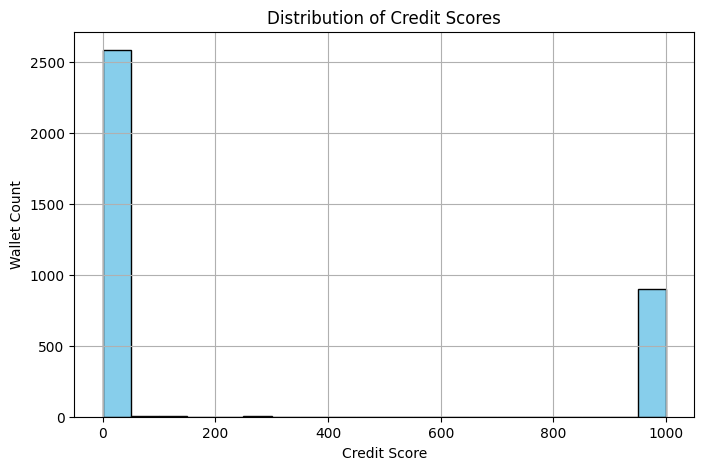

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/wallet_scores.csv")
plt.figure(figsize=(8,5))
df['credit_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [10]:
features = pd.read_csv("data/wallet_features.csv")
scores = pd.read_csv("data/wallet_scores.csv")
df = features.merge(scores, on="wallet")

df['score_segment'] = pd.cut(df['credit_score'], bins=[0,300,700,1000], labels=['Low', 'Medium', 'High'])

grouped = df.groupby('score_segment')[
    ['total_deposit', 'total_borrow', 'total_repay', 'total_liquidation', 'repay_borrow_ratio', 'tx_count']
].mean().round(2)

print(grouped)


               total_deposit  total_borrow   total_repay  total_liquidation  \
score_segment                                                                 
Low             7.940702e+16  4.582300e+16  1.704687e+16                0.0   
Medium          2.913563e+15  4.689546e+14  2.330107e+14                0.0   
High            3.704764e+16  7.988455e+15  8.838987e+15                0.0   

               repay_borrow_ratio  tx_count  
score_segment                                
Low                  2.000000e-01     80.15  
Medium               5.000000e-01    159.00  
High                 1.814797e+09     56.52  


/tmp/ipython-input-10-4268516708.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('score_segment')[
